# <p style="background-color:#5C0795;font-family:newtimeroman; color:white; text-align:center; font-size:40px; padding:12px; border-radius:20px;">SMS Filter: Spam ❌ or Ham ✅</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <p style="background-color:purple;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">IMPORTING LIBRARIES</p>

In [ ]:
import re
import warnings

import numpy as np

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score

warnings.filterwarnings('ignore')

# <p style="background-color:purple;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">DATA LOADING & EXPLORATION</p>

In [ ]:
#Loading data
df = pd.read_csv("/content/drive/MyDrive/spam.csv", encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Dropping the redundent columns & Renaming the columns
df = df.drop(columns = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)
df.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# shape
df.shape

(5572, 2)

In [ ]:
# information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
# null data
df.isnull().sum()

,0
Target,0
Text,0


In [ ]:
# duplicate data
df.duplicated().sum()

403

In [ ]:
# dropping duplicate data
df.drop_duplicates(inplace=True)

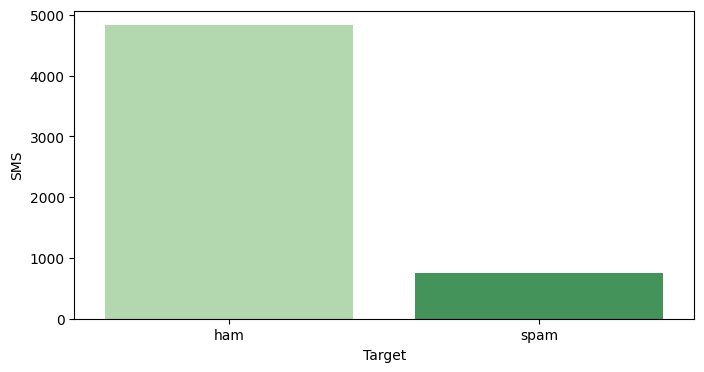

In [ ]:
# target feature
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Target', palette='Greens')
plt.xlabel("Target")
plt.ylabel("SMS")
plt.show()

`Note` - Data Is Imbalanced

# <p style="background-color:purple;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">FEATURE ENGINEERING</p>

In [ ]:
import nltk
nltk.download('punkt')

df['No of Chars'] = df['Text'].apply(len)
df['No of Sentences'] = df['Text'].apply(lambda corpus: nltk.sent_tokenize(corpus)).apply(len)
df['No of Words'] = df['Text'].apply(lambda document: nltk.word_tokenize(document)).apply(len)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# data desciption
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No of Chars,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,910.0
No of Sentences,5169.0,1.965564,1.448541,1.0,1.0,1.0,2.0,38.0
No of Words,5169.0,18.455794,13.324758,1.0,9.0,15.0,26.0,220.0


# <p style="background-color:purple;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">DETECTING & HANDLING OUTLIERS </p>

`Note`: From the above plot, we can clearly see their are few outliers, all in the class ham.

In [ ]:
# Identifying Outliers Using IQR
column_name = 'No of Chars'

Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
outliers.index

Index([  53,  154,  380,  472,  550,  710,  837,  881, 1084, 1359, 1384, 1512,
       1578, 1585, 1826, 1862, 2009, 2011, 2064, 2089, 2133, 2157, 2355, 2369,
       2379, 2407, 2433, 2502, 2544, 2680, 2847, 2855, 2944, 2970, 3015, 3039,
       3105, 3225, 3278, 3304, 3349, 3452, 3516, 3564, 3730, 3736, 3777, 3878,
       4055, 4079, 4220, 4289, 4310, 4397, 4407, 4450, 4454, 4865, 4888, 4903,
       5082, 5104, 5129, 5209, 5264, 5451, 5535, 5557],
      dtype='int64')

In [ ]:
# Dropping the outliers
df.drop(outliers.index, axis=0, inplace=True)

In [ ]:
# Shape after dropping outliers
df.shape

(5504, 5)

# <p style="background-color:purple;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">DATA PRE-PROCESSING</p>

## <p style="background-color:teal;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">DATA CLEANING</p>

In [ ]:
# Function to clean the data
def data_cleaning(text):
    text = re.sub('[^a-zA-Z]', ' ', text) # replacing all non-alphabetix characters with space
    text = str.lower(text) # lowercasing
    text = text.split()    # splitting string into list
    text = ' '.join(text)  # join all items of the list
    return text


# applying data cleaning and creating new feature
df['Clean Text'] = df['Text'].apply(data_cleaning)

## <p style="background-color:teal;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">TOKENIZATION</p>

In [ ]:
# Applying Word Tokenization & Creating new feature
df['Tokenized Text'] = df['Clean Text'].apply(lambda document: nltk.word_tokenize(document))

## <p style="background-color:teal;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">REMOVING STOPWARDS</p>

In [ ]:
import nltk
nltk.download('stopwords')
# Function to remove stopwords from tokenized text
def stopwords_removal(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in tokens if word not in stop_words]
    return filtered_text


# applying stopwords removal
df['Filtered Token'] = df['Tokenized Text'].apply(stopwords_removal)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## <p style="background-color:teal;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">LEMMATIZATION</p>

`I was getting Error While Performing Lemmatization`:

Resource 'corpora/wordnet' not found. Please use the NLTK
Downloader to obtain the resource: >>> nltk.download()
Searched in:
- '/root/nltk_data'
- '/usr/share/nltk_data'
- '/usr/local/share/nltk_data'
- '/usr/lib/nltk_data'
- '/usr/local/lib/nltk_data'


`TO solve, run this code`:

In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [ ]:
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Function to lemmatize
def lemmatizing(tokens):
    lemmas = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return lemmas


df['Lemmatized Tokens'] = df['Filtered Token'].apply(lemmatizing)

[nltk_data] Downloading package wordnet to /root/nltk_data...


# <p style="background-color:purple;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">WORD EMBEDDING | VECTORIZING</p>

In [ ]:
# Creating a corpus of Lemmatized Tokens
corpus = []
for tokens in df['Lemmatized Tokens']:
    document = ' '.join([word for word in tokens])
    corpus.append(document)

In [ ]:
# Performing Vectorization and creating independent feature
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

In [ ]:
# Encoding Dependent Features
df['Target'] = df['Target'].map({"ham":0, "spam":1})
y = df['Target']

# <p style="background-color:purple;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">MODEL TRAINING</p>

# <p style="background-color:purple;font-family:newtimeroman; color:white; text-align:center; font-size:30px; padding:8px; border-radius:20px;">THANK YOU! 😊</p>